In [2]:
def analyse_my_stock_portfolio2(tickers, timeframe, start_date, end_date, weights, simulate, inv_amt, num_sim, num_trade_days, plot):
   
    # Import packages required
    import sys
    import pandas as pd
    import numpy as np
    import datetime as dt
    from pathlib import Path
    import matplotlib.pyplot as plt 
    from matplotlib.gridspec import GridSpec
    import seaborn as sns
    import os
    import json
    import requests
    from dotenv import load_dotenv
    import alpaca_trade_api as tradeapi
    from MCForecastTools import MCSimulation
    %matplotlib inline
    load_dotenv()     
    
    
    
                                 ####################################################################### Data Setup #######################################################################

    
    #Define variables
    tickers = tickers
    tf = timeframe
    start_date = pd.Timestamp(start_date, tz='America/New_York').isoformat()
    end_date = pd.Timestamp(end_date, tz='America/New_York').isoformat()
    num_sim = num_sim
    wt=weights
    num_trade_days=num_trade_days   
    simulate = simulate
    
    #Read in alpaca keys
    alpaca_key = os.getenv('ALPACA_API_KEY')
    alpaca_secret_key = os.getenv('ALPACA_API_SECRET_KEY')
    
    print(f"Your alpaca key is {type(alpaca_key)}.")
    print(f"Your alpaca secret key is {type(alpaca_secret_key)}.")
    
    #Set up Alpaca trade api
    api = tradeapi.REST(alpaca_key, alpaca_secret_key, api_version='V2')
    
    #Define parameters to get stock data from Alpaca api
    tickers_df = api.get_barset(tickers, timeframe=tf, start=start_date, end=end_date, limit=1000).df
    print()
    print()
    print(f"This is your dataframe: \n {tickers_df.head()} with {tickers_df.shape} rows (represnts no. of days) and columns")
    
    #Calc daily returns
    close_prices = tickers_df.loc(axis=1)[:,'close']
    print()
    print()
    print(f"These are your close prices:\n {close_prices}")  
    print()   
      
        
        
                                 ####################################################################### ANALYSES #######################################################################

   

    daily_returns = close_prices.pct_change().dropna()
    print()
    print()
    print(f"These are your daily returns:\n {daily_returns}")  
    print()   
       
    #Calc portfolio and cumulative returns
    portfolio_cum_return = (1+daily_returns).cumprod()  
    
    #Calc 21-day rolling std dev
    roll_std = daily_returns.rolling(window=21).std()

    #Calc correlation
    correlation = daily_returns.corr()
    print()
    print()
    print(f"This is your correlation matrix \n {correlation}")  
    print()  
    
    # Calculate Annualzied Sharpe Ratios
    sharpe_ratio = (daily_returns.mean()*252) / (daily_returns.std()*np.sqrt(252))
    print()
    print()
    print(f"This is your Sharpe Ratio:\n {sharpe_ratio}")  
    print()      
    
    #Define paramters to run Monte-Carlo Simulation
    MC = MCSimulation(portfolio_data=tickers_df, weights=wt, num_simulation=num_sim, num_trading_days=num_trade_days)
    print()
    print(f"This is your portfolio for Monte-Carlo simulation: \n {MC.portfolio_data.head()}")
    print()     
    
    
    if simulate == 'yes':
        #Run Monte-Carlo simulation to determine cumulative returns
        print("Running simulation..........................")
        print()
        print()
        print()
        
        #Summarise cumulative returns
        MC_summary = MC.summarize_cumulative_return()
        print()
        print(f"Here is the summary of the Monte-Carlo simulation {MC_summary}")
        
        #Extract confidence interval to determine range for future cumulative returns
        ci_lower = round(MC_summary[8] * inv_amt, 2)
        ci_upper = round(MC_summary[9] * inv_amt, 2)
    
        print()
        print(f"If you were to invest ${inv_amt} in {tickers[0:]} with a weighting of {wt}, then your invested amount could range from ${ci_lower} to ${ci_upper} after {num_trade_days} trading days or {num_trade_days/252} years.")
        print()
        print()
        print()

    elif simulate == 'no':
            pass
    else: 
            pass
    
 
                                 ####################################################################### Plots #######################################################################
                   
    
    #Plot daily returns
    fig1 = plt.figure()
    plot1 = daily_returns.plot(title='Daily returns', figsize=(15, 10))   
    plot1.set_xlabel("")
    plot1.figure.savefig('DailyReturns_LinePlot.png', bbox_inches="tight") 
    
    #Plot daily returns_box  
    fig2 = plt.figure()
    plot2 = sns.boxplot(data=daily_returns).set_title('Daily returns')
    sns.set(rc={'figure.figsize':(15, 10)})
    plot2.figure.savefig('DailyReturns_BoxPlot.png', bbox_inches="tight")
    
    #Plot cumulative returns
    fig3 = plt.figure()
    plot3 = portfolio_cum_return.plot(title='Cumulative Returns', figsize=(15, 10))
    plot3.set_xlabel("")
    plot3.figure.savefig('CumulativeReturns.png', bbox_inches="tight")

    #Plot 21-day rolling std dev
    fig4 = plt.figure()
    plot4 = roll_std.plot(figsize=(15, 10), title='Rolling 21-day standard deviation')
    plot4.set_xlabel(" ")
    plot4.figure.savefig('21-day_rol_StdDev.png', bbox_inches="tight")

    #Plot correlation
    fig5 = plt.figure()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)  
    plot5 = sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, cmap=cmap, mask=mask)
    sns.set(rc={'figure.figsize':(15,10)})
    plot5.figure.savefig('Correlation.png', bbox_inches="tight")

    #Plot Sharpe Ratio
    fig6 = plt.figure()
    plot6 = sharpe_ratio.plot(kind='bar', title='Sharpe ratios', edgecolor='red', color='black', ylabel='Sharpe ratio', xlabel='Portfolios', figsize=(15, 10))
    plot6.figure.savefig('SharpeRatio.png', bbox_inches="tight")

    plt.show()
    
   #Save outputs to text file
    with open('Summary.txt', 'w') as sys.stdout:
        print(f"Your alpaca key is {type(alpaca_key)}.")
        print(f"Your alpaca secret key is {type(alpaca_secret_key)}.")
        print(f"This is your dataframe: \n {tickers_df.head()} with {tickers_df.shape} rows (represnts no. of days) and columns")
        print(f"These are your close prices:\n {close_prices}")  
        print(f"This is your correlation matrix \n {correlation}")  
        print(f"This is your Sharpe Ratio:\n {sharpe_ratio}")  
        print(f"This is your portfolio for Monte-Carlo simulation: \n {MC.portfolio_data.head()}")
        print(f"Here is the summary of the Monte-Carlo simulation {MC_summary}")
        print(f"If you were to invest ${inv_amt} in {tickers[0:]} with a weighting of {wt}, then your invested amount could range from ${ci_lower} to ${ci_upper} after {num_trade_days} trading days or {num_trade_days/252} years.")


Your alpaca key is <class 'str'>.
Your alpaca secret key is <class 'str'>.


This is your dataframe: 
                               DIS                                       NKE  \
                             open    high     low   close     volume   open   
time                                                                          
2017-01-10 00:00:00-05:00     NaN     NaN     NaN     NaN        NaN    NaN   
2017-01-11 00:00:00-05:00     NaN     NaN     NaN     NaN        NaN    NaN   
2017-01-12 00:00:00-05:00  106.45  107.91  105.85  107.54  7083008.0  52.52   
2017-01-13 00:00:00-05:00  107.16  108.35  105.28  108.04  5418242.0  52.59   
2017-01-17 00:00:00-05:00  107.91  108.93  106.19  107.96  5970927.0  53.40   

                                                             ...      V  \
                            high    low    close     volume  ...   open   
time                                                         ...          
2017-01-10 00:00:00-05:00    NaN    NaN

<Figure size 432x288 with 0 Axes>

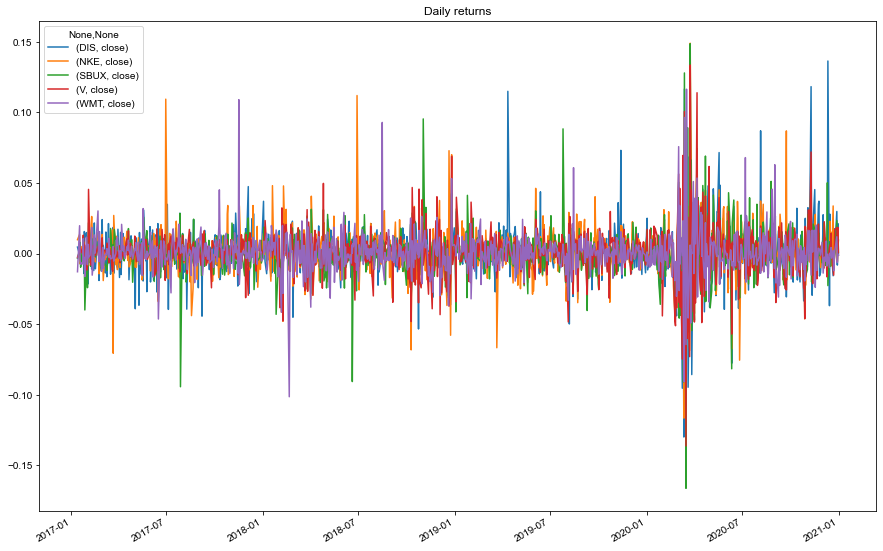

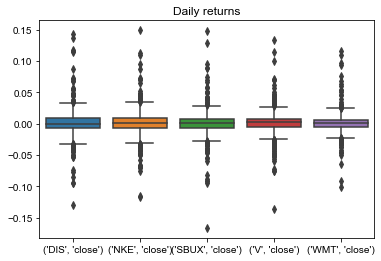

<Figure size 1080x720 with 0 Axes>

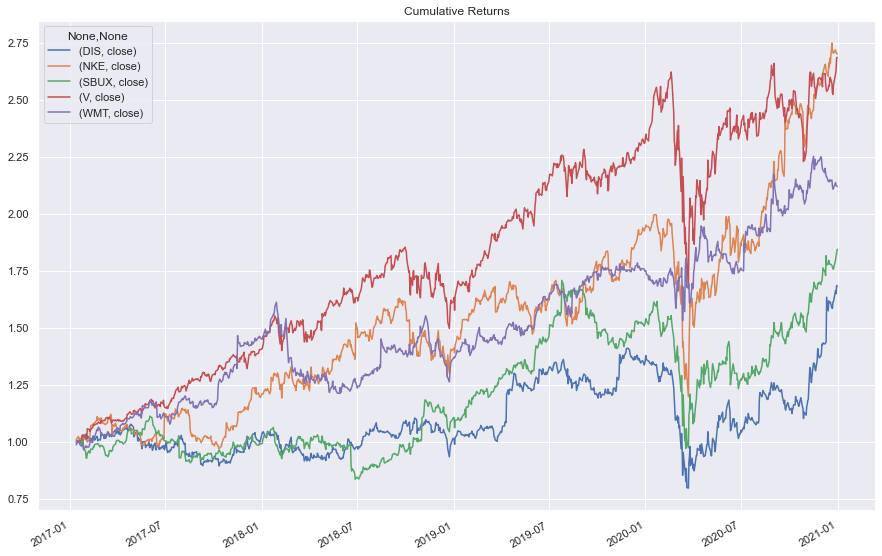

<Figure size 1080x720 with 0 Axes>

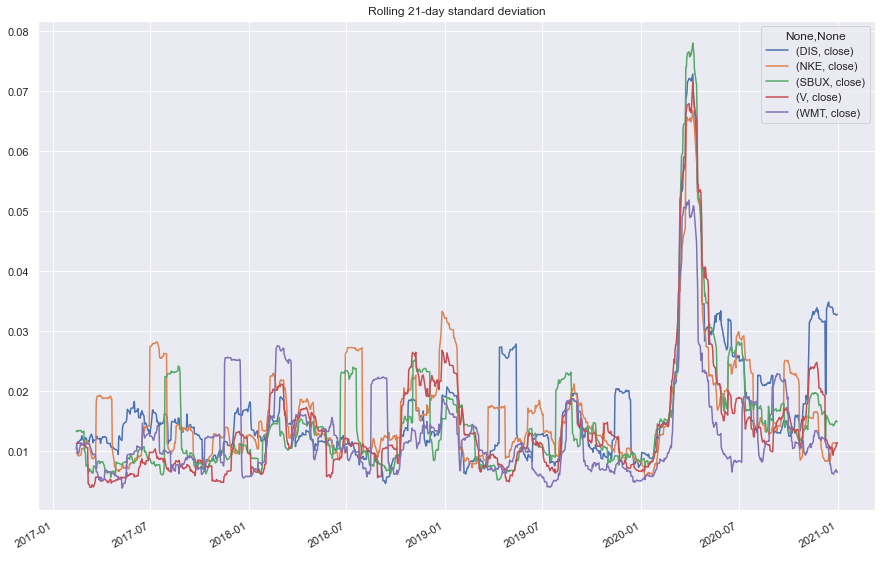

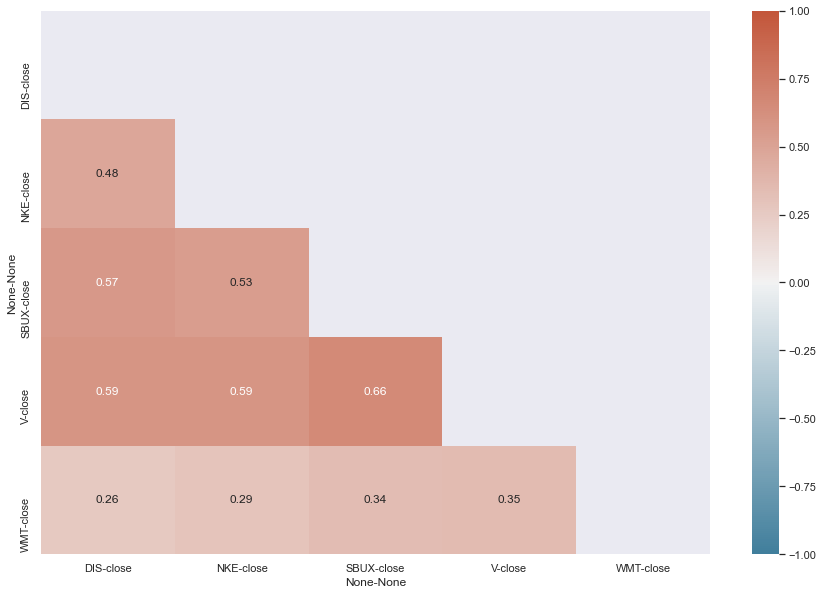

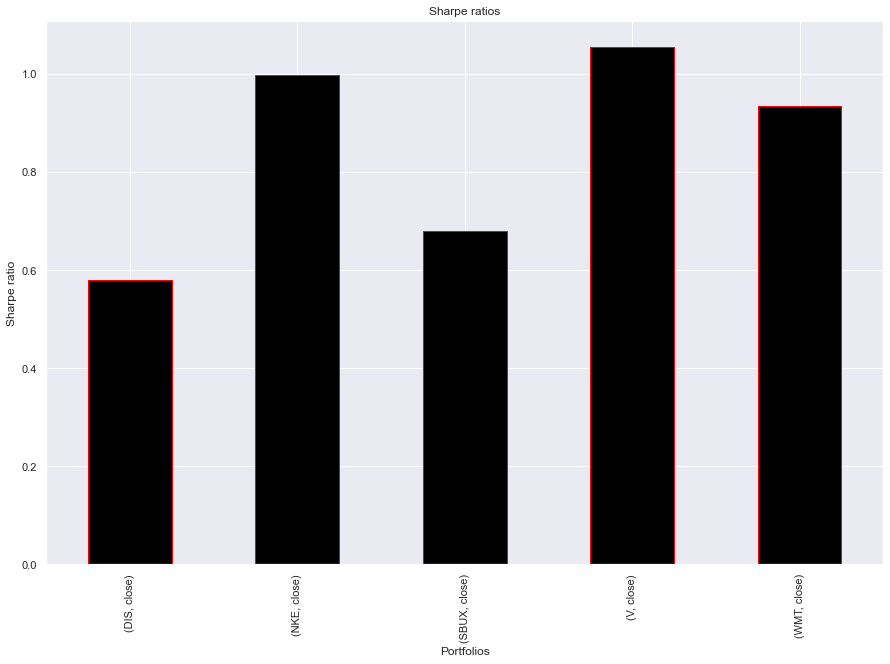

In [ ]:
tickers = ['NKE', 'SBUX', 'WMT', 'V', 'DIS']

timeframe = '1D'

start_date = "2019-1-1"

end_date = '2021-1-1'

weights = [0.20, 0.20, 0.20, 0.20, 0.20] 

simulate = 'yes'

inv_amt = 20000

num_sim = 50

num_trade_days = 50

plot = '21_day_roll'

analyse_my_stock_portfolio2(tickers, timeframe, start_date, end_date, weights, simulate, inv_amt, num_sim, num_trade_days, plot)
   